**If you think this notebook deserves an upvote, I'd love to have it. An upvote per view, its all I ask**
(credit to [Dan Carlin](https://twitter.com/HardcoreHistory) for coining the phrase ;-) 

---------------------------------------

This is part of a series of notebooks about practical time series methods:

* [Part 0: the basics](https://www.kaggle.com/konradb/ts-0-the-basics)
* [Part 1a: smoothing methods](https://www.kaggle.com/konradb/ts-1a-smoothing-methods)
* [Part 1b: Prophet](https://www.kaggle.com/konradb/ts-1b-prophet) 
* [Part 2: ARMA](https://www.kaggle.com/konradb/ts-2-arma-and-friends)
* [Part 3: Time series for finance](https://www.kaggle.com/konradb/ts-3-time-series-for-finance) 
* [Part 4: Sales and demand forecasting](https://www.kaggle.com/konradb/ts-4-sales-and-demand-forecasting)
* [Part 5: Automatic for the people](https://www.kaggle.com/code/konradb/ts-5-automatic-for-the-people) 
* [Part 6: Deep learning for TS - sequences](https://www.kaggle.com/konradb/ts-6-deep-learning-for-ts-sequences)
* [Part 7: Survival analysis](https://www.kaggle.com/konradb/ts-7-survival-analysis)
* [Part 8: Hierarchical time series](https://www.kaggle.com/konradb/ts-8-hierarchical-time-series) 
* [Part 9: Hybrid methods](https://www.kaggle.com/konradb/ts-9-hybrid-methods) - **this notebook**
* [Part 10: Validation methods for time series](https://www.kaggle.com/code/konradb/ts-10-validation-methods-for-time-series/)
* [Part 11: Transfer learning](https://www.kaggle.com/code/konradb/ts-11-deep-learning-for-ts-transfer-learning)


The series is accompanied by video presentations on the YouTube channel of [Abhishek](https://www.kaggle.com/abhishek):

* [Talk 0](https://www.youtube.com/watch?v=cKzXOOtOXYY) 
* [Talk 1](https://www.youtube.com/watch?v=kAI67Sz92-s) - combining the content from parts 1a and 1b
* [Talk 2](https://www.youtube.com/watch?v=LjV5DE3KR-U) 
* [Talk 3](https://www.youtube.com/watch?v=74rDhJexmTg)
* [Talk 4](https://www.youtube.com/watch?v=RdH8zd07u2E) 
* [Talk 5](https://www.youtube.com/watch?v=wBP8Pc4Wxzs) 
* [Talk 6](https://www.youtube.com/watch?v=81AEI0tj0Kk) 
* [Talk 7](https://www.youtube.com/watch?v=m-8I_hkmz9o)
* [Talk 8](https://www.youtube.com/watch?v=7ZTarg4QYR4)
* [Talk 9](https://www.youtube.com/watch?v=NYZzBvKcfp4)
* [Talk 10](https://www.youtube.com/watch?v=47WeBiLV2Uo)
* [Talk 11]()


---------------------------------------

In our journey through the time series universe, we have covered both vintage models and modern ones. Not surprisingly, different approaches try to mix the two and in this episode we will look at some of the hybrid models created in this manner. This umbrella episode will gather different models proposed for handling time series in the pre-Transformer era: 

* [ES-RNN](#esrnn)
* [Temporal convolution](#cnn1d)
* [N-Beats](#nbeats)

Remember: it's all connected 

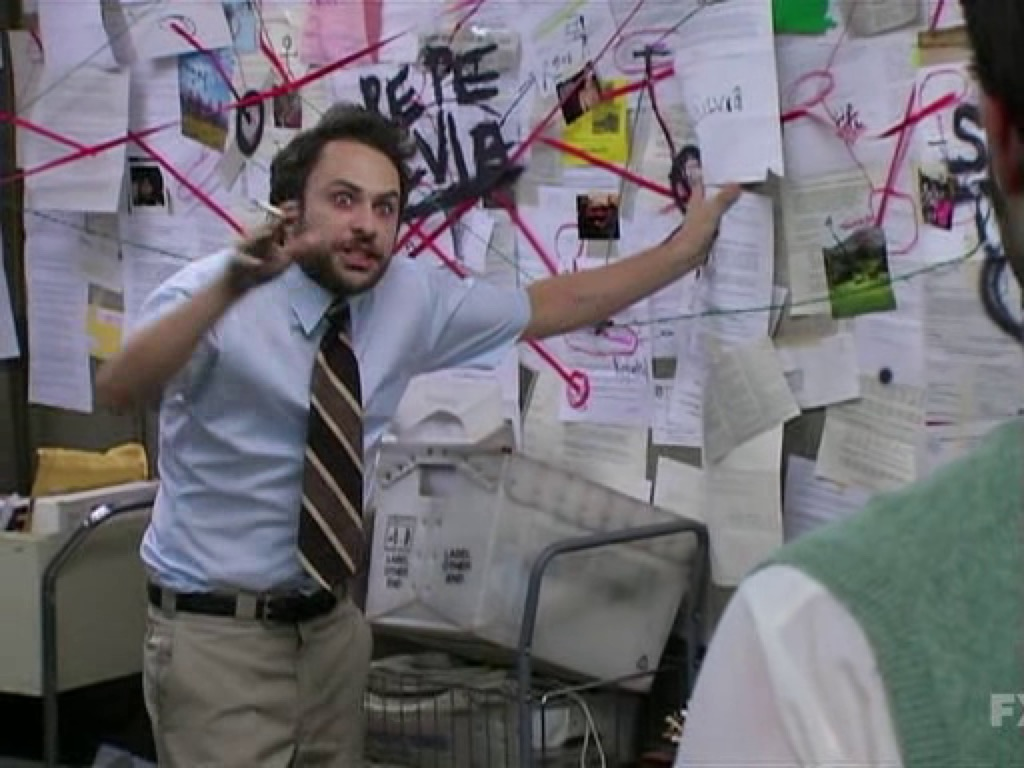


In [1]:
import numpy as np
import pandas as pd
import os

from sklearn.metrics import mean_squared_error as mse

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight') 


In [2]:
# general settings
class CFG:
    data_folder = '../input/tsdata-1/'
    img_dim1 = 20
    img_dim2 = 10

# adjust the parameters for displayed figures    
plt.rcParams.update({'figure.figsize': (CFG.img_dim1,CFG.img_dim2)})   

In [3]:
def my_rmse(x,y):
    return(np.round( np.sqrt(mse(x.values,y.values)) ,4))


def eval_model(model, flow,
               past_covariates=None,  future_covariates=None,
              retrain = False,
              forecast_horizon = 10,
              last_obs = 200):
    # Past and future covariates are optional because they won't always be used in our tests
    
    # We backtest the model on the last 20% of the flow series, 
    # with a horizon of `forecast_horizon` steps:
    backtest = model.historical_forecasts(series=flow, 
                                          past_covariates=past_covariates,
                                          future_covariates=future_covariates,
                                          start=0.8, 
                                          retrain=retrain,
                                          verbose=True, 
                                          forecast_horizon=forecast_horizon)
    
    flow[-len(backtest) - last_obs:].plot()
    backtest.plot(label='backtest (n=' + str(forecast_horizon) + ')')
    
    print('Backtest RMSE = {}'.format(np.round( rmse(flow, backtest),2 )))
    

In [4]:
!pip install llvmlite --ignore-installed

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.6/34.6 MB 9.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.55.1 requires llvmlite<0.39,>=0.38.0rc1, but you have llvmlite 0.39.1 which is incompatible.


In [5]:
!pip install ESRNN

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 150.9 kB/s eta 0:00:00


<a id="esrnn"></a>
# ES + RNN

Exponential smoothing is one of the most classic methods for time series, reducing the modeling problem to curve fitting - and (pre-Transformer ;-) RNN/LSTM were the hottest thing in sequence modeling. Each has certain advantages, so - in hindsight - it seems obvious that somebody would try and combine the two. That somebody is a brilliant geezer named Slawek Smyl (Uber then, Meta now) who won the [M4 Forecasting Competition](https://www.sciencedirect.com/science/article/pii/S0169207019301128) in 2018 using a model combining the two. The original paper introducing them model can be found [here](https://www.sciencedirect.com/science/article/abs/pii/S0169207019301153); below we give a brief recap:

- ES-RNN is a statistics + ML hybrid

- triple exponential smoothing is a classic - still used today

- issue 1: works for a **linear** trend

- issue 2: fitted per series $\implies$ no cros-series training 

- RNN work for multiple series, but require LOTS of parameters

- solution: plug RNN for the trend component

\begin{align}
l_t &= \alpha \left(\frac{y_t}{s_t} \right) + (1- \alpha) l_{t-1} \\
s_{t+m} &= \gamma \frac{y_t}{l_t} + (1- \gamma) s_t \\
\hat{y}_{t+1 \ldots t+h} &= RNN(\tau_t) * l_t * s_{t+1 \ldots t+h}
\end{align}

- global vs per-series components 

- ES parameters are specific for each time series

- RNN is trained with all the series, has shared parameters and it is used to learn common local trends among the series

- those are not observed AND must be comparable $\rightarrow$ ES decomposition results are normalized and have seasonality removed

[Source](https://medium.com/analytics-vidhya/forecasting-in-python-with-esrnn-model-75f7fae1d242)

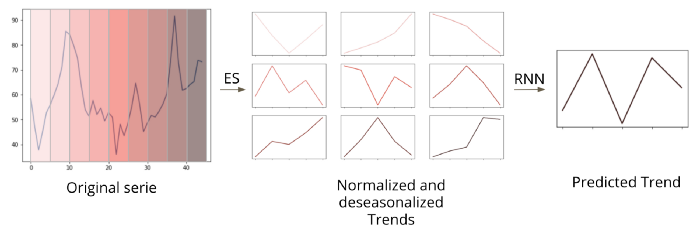



- the model optimizes two losses: quantile loss + regularization

\begin{equation}
L_q(y, \hat{y}) = q(y - \hat{y} )_{+} + (1- q) ( \hat{y} - y)_{+}
\end{equation}


While numerous implementations of (variants of) ES-RNN can be found online, we will use a PyTorch implementation via ESRNN: https://pypi.org/project/ESRNN/

In [6]:

from ESRNN import ESRNN
from ESRNN.m4_data import *
from ESRNN.utils_evaluation import evaluate_prediction_owa
from ESRNN.utils_visualization import plot_grid_prediction



In [7]:
!cd ../working && mkdir m4

In [8]:
X_train_df, y_train_df, X_test_df, y_test_df = prepare_m4_data( dataset_name="Hourly", 
   directory="../working/m4", 
   num_obs=414)



Successfully downloaded M4-info.csv 4335598 bytes.
Successfully downloaded Train/Daily-train.csv 95765153 bytes.
Successfully downloaded Train/Hourly-train.csv 2347115 bytes.
Successfully downloaded Train/Monthly-train.csv 91655432 bytes.
Successfully downloaded Train/Quarterly-train.csv 38788547 bytes.
Successfully downloaded Train/Weekly-train.csv 4015067 bytes.
Successfully downloaded Train/Yearly-train.csv 25355736 bytes.
Successfully downloaded Test/Daily-test.csv 576459 bytes.
Successfully downloaded Test/Hourly-test.csv 132820 bytes.
Successfully downloaded Test/Monthly-test.csv 7942698 bytes.
Successfully downloaded Test/Quarterly-test.csv 1971754 bytes.
Successfully downloaded Test/Weekly-test.csv 44247 bytes.
Successfully downloaded Test/Yearly-test.csv 1486434 bytes.


Preparing Hourly dataset
Preparing Naive2 Hourly dataset predictions


In [9]:
X_train_df.head(5)

unique_id                  ds      x
0        H1 1970-01-01 00:00:00  Other
1        H1 1970-01-01 01:00:00  Other
2        H1 1970-01-01 02:00:00  Other
3        H1 1970-01-01 03:00:00  Other
4        H1 1970-01-01 04:00:00  Other

Instantiating the model is straightforward: 

In [10]:
# Instantiate model
model = ESRNN(max_epochs=5, 
              # frequency of computing and reporting this loss
              freq_of_test=1, 
              batch_size=32, 
              
              # customize things around the learning rate
              learning_rate=0.02, per_series_lr_multip=0.5,
              lr_scheduler_step_size=7, lr_decay=0.5, 
              
              gradient_clipping_threshold=50, 
              rnn_weight_decay=0.0, noise_std=0.001, 
              level_variability_penalty=30, 
              
              # for probabilistic forecasting
              testing_percentile=50, training_percentile=50,
              
              ensemble=True, max_periods=371, 
              seasonality=[24, 168], input_size=24, output_size=48,
              cell_type='LSTM', state_hsize=40, 
              dilations=[[1, 4, 24, 168]], 
              add_nl_layer=False,
              random_seed=1, device='cpu')

In [11]:
# If y_test_df is provided the model will evaluate predictions on this set every freq_test epochs
model.fit(X_train_df, y_train_df)

Infered frequency: H
=============== Training ESRNN  ===============

========= Epoch 0 finished =========
Training time: 31.83436
Training loss (50 prc): 0.70241
========= Epoch 1 finished =========
Training time: 32.66036
Training loss (50 prc): 0.59290
========= Epoch 2 finished =========
Training time: 32.39614
Training loss (50 prc): 0.53480
========= Epoch 3 finished =========
Training time: 32.7486
Training loss (50 prc): 0.49681
========= Epoch 4 finished =========
Training time: 31.65299
Training loss (50 prc): 0.46950
Train finished! 



OWA = Overall Weighted Average was the metric in the M4 competition $\rightarrow$ that's what gave fame to this model...

In [12]:
# Predict on test set
y_hat_df = model.predict(X_test_df)

# Evaluate predictions
final_owa, final_mase, final_smape = evaluate_prediction_owa(y_hat_df, y_train_df, 
                                                             X_test_df, y_test_df,
                                                             naive2_seasonality=24)

===============  Model evaluation  ==============
OWA: 0.985 
SMAPE: 15.618 
MASE: 2.685 


We van visualise the predictions:

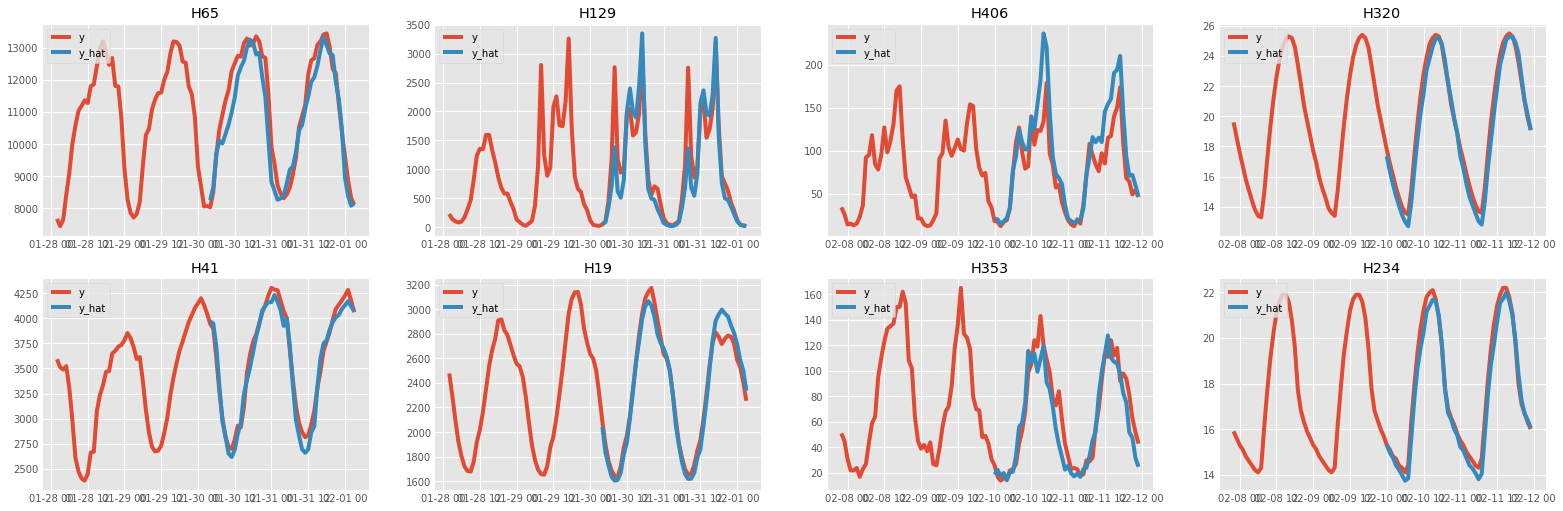

In [13]:
unique_ids = ['H129', 'H41', 'H406', 'H234', 
               'H65', 'H19', 'H320', 'H353']

plot_preds = pd.concat([y_train_df.groupby('unique_id').tail(50), 
                        y_test_df],  sort=True)

plot_grid_prediction(plot_preds, y_hat_df,  unique_ids=unique_ids)


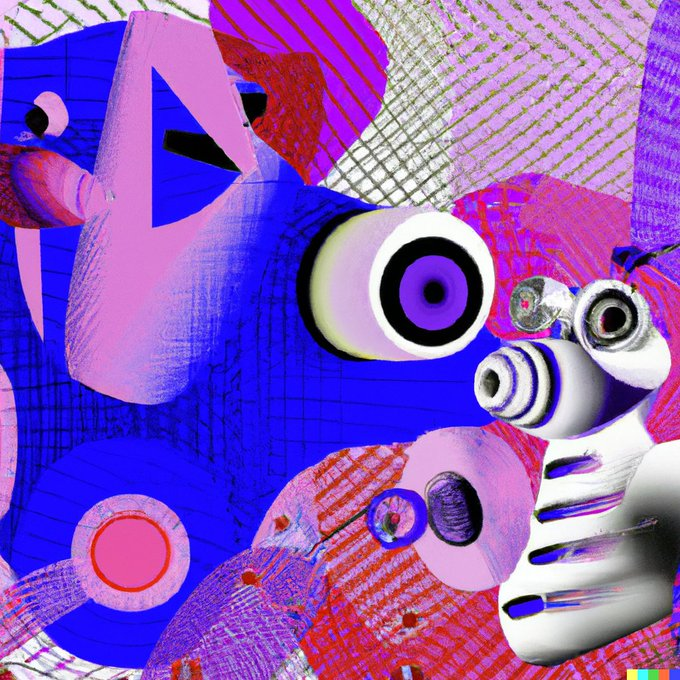

<a id="cnn1d"></a>
# Temporal convolution

Convolution is the *C* in CNN - **the** architecture that probably got most of us into deep learning, starting around 2012 and computer vision problems. In 2018 an idea was put forth [by Bai et al](https://arxiv.org/abs/1803.01271): what if we apply convolution to sequence modeling, a field ruled (in DL) by RNN / LSTM / GRU (see [Episode 6](https://www.kaggle.com/code/konradb/ts-6-deep-learning-for-ts-rnn-and-friends))? The authors showed some promising results: avoiding gradient problems, reducing memory retention, and performance improvement via parallelization. 

The architecture is called **Temporal Convolutional Network** (TCN) - below we provide a summary focusing on the important bits from a time series angle:

* TL;DR **TCN = 1D FCN + causal convolutions**

* A **convolution** is an operation in integral calculus expressing how the shape of one function is modified by the other $\rightarrow$ reflects similarity of two sequences ($\sim$ cross correlation)

[Source](https://medium.com/unit8-machine-learning-publication/temporal-convolutional-networks-and-forecasting-5ce1b6e97ce4) 

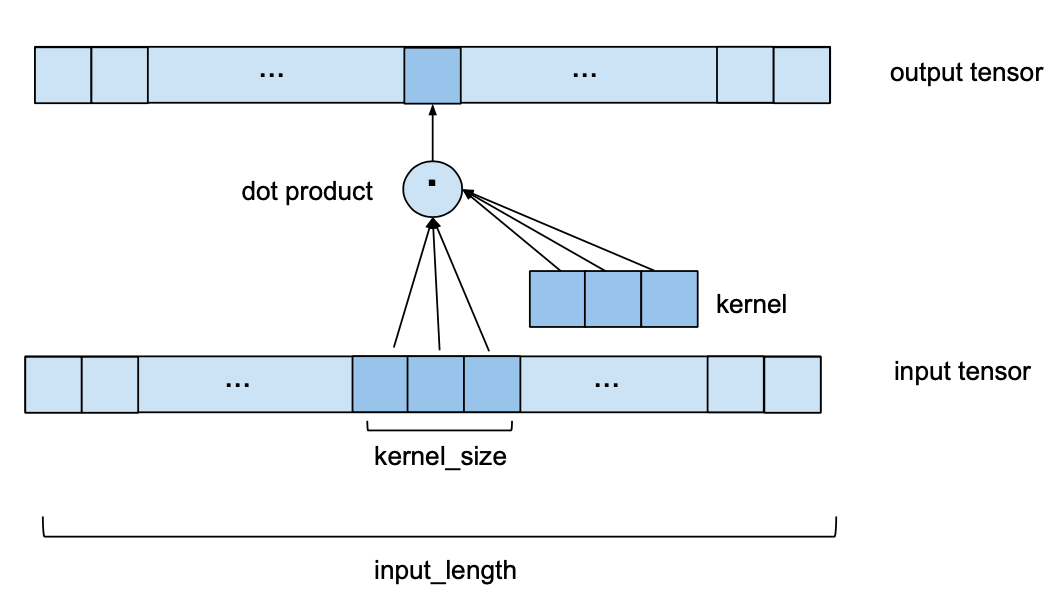




* CNN = input + hidden (convolutional, pooling, fully connected) + output

[Source](https://towardsdatascience.com/farewell-rnns-welcome-tcns-dd76674707c8)

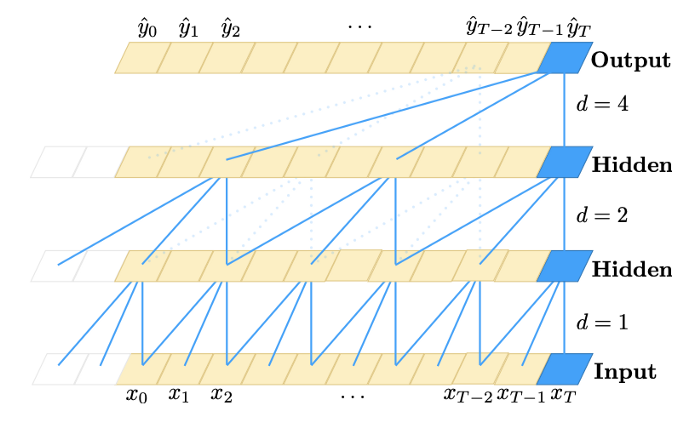



* Node input = receptive field

* CNN apply filters to the input to detect features $\rightarrow$ CV: lines, shapes, TS: trend, seasonality

* **for time series convolution must be causal**: only looking back in time in the input sequence 

* causal convolution: output at time $t$ is convolved only with elements from time $\leq t$ in the previous layer

* lookback at history $\sim$ depth of the network $\implies$ introducing dilation

* the math: given sequence $x \in $ $\mathbb{R}^n$ and filter $f: \{0, \ldots, k-1 \} \rightarrow \mathbb{R}$, dilated convolution operation $F$ on element s of the sequence is defined 

\begin{equation}
F(s) = (x \star_d f )(s) = \sum_{i=0}^{k-1} f(i) x_{s - d*i}
\end{equation}

where $d$ is the dilation factor, $k$ is the filter size, and $s − d * i$ accounts for the direction of the past. 

* dilation $\iff$ fixed step between two adjacent filter taps 

* dilations expand the receptive field $\implies$ longer historical periods 

* output length = input length $\rightarrow$ FCN with zero padding (each hidden layer size = input layer size)

[Source](https://medium.com/unit8-machine-learning-publication/temporal-convolutional-networks-and-forecasting-5ce1b6e97ce4) 

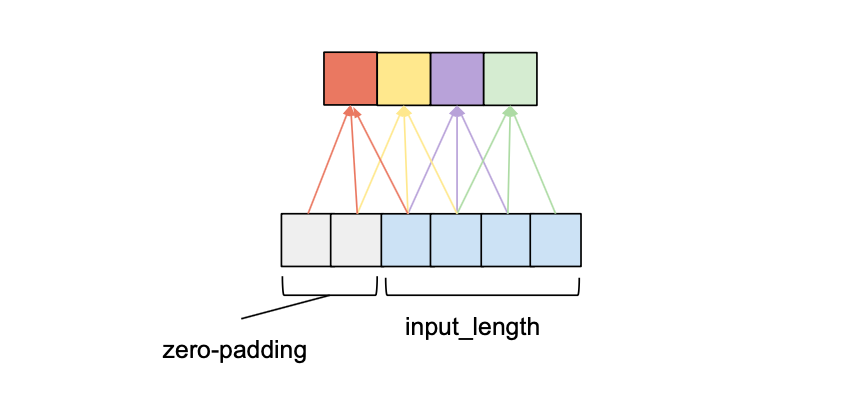


TCN pros : 

* parallelism $\rightarrow$ same filter in each layer $\implies$ long input sequence can be processed in its entirety

* stable gradients: backpropagation path $\neq$ temporal direction of the sequence 

* low memory req $\rightarrow$ filters shared across a layer, backprop $\sim$ network depth

* variable length input: same as RNN et al

* customizable receptive field size - more dilated layers / large dilation factors / filter size


TCN issues:

* evaluation: TCN needs entire raw sequence up to the effective history length


For a demonstration of TCN we will be using the `darts` package, which we already met in [episode 5](https://www.kaggle.com/code/konradb/ts-5-automatic-for-the-people#Darts) - while in principle TCN can be built from scratch using [INSERT YOUR PREFERRED DL FRAMEWORK] (like [here](https://www.kaggle.com/code/christofhenkel/temporal-convolutional-network)), we can make our lives a little easier ;-)

In [14]:
!pip install darts[all]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 424.1/424.1 kB 622.8 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 11.8 MB/s eta 0:00:00
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.39.1
    Uninstalling llvmlite-0.39.1:
      Successfully uninstalled llvmlite-0.39.1


In [15]:
from darts import TimeSeries
from darts.dataprocessing.transformers import MissingValuesFiller


df = pd.read_csv("../input/hourly-energy-consumption/COMED_hourly.csv",parse_dates = True)
df = df.loc[df["Datetime"] > '2011-12-31'].reset_index(drop = True)
df.columns = ['timestamp', 'energy_mw']
df.head(5)

timestamp  energy_mw
0  2011-12-31 01:00:00     9970.0
1  2011-12-31 02:00:00     9428.0
2  2011-12-31 03:00:00     9059.0
3  2011-12-31 04:00:00     8817.0
4  2011-12-31 05:00:00     8743.0

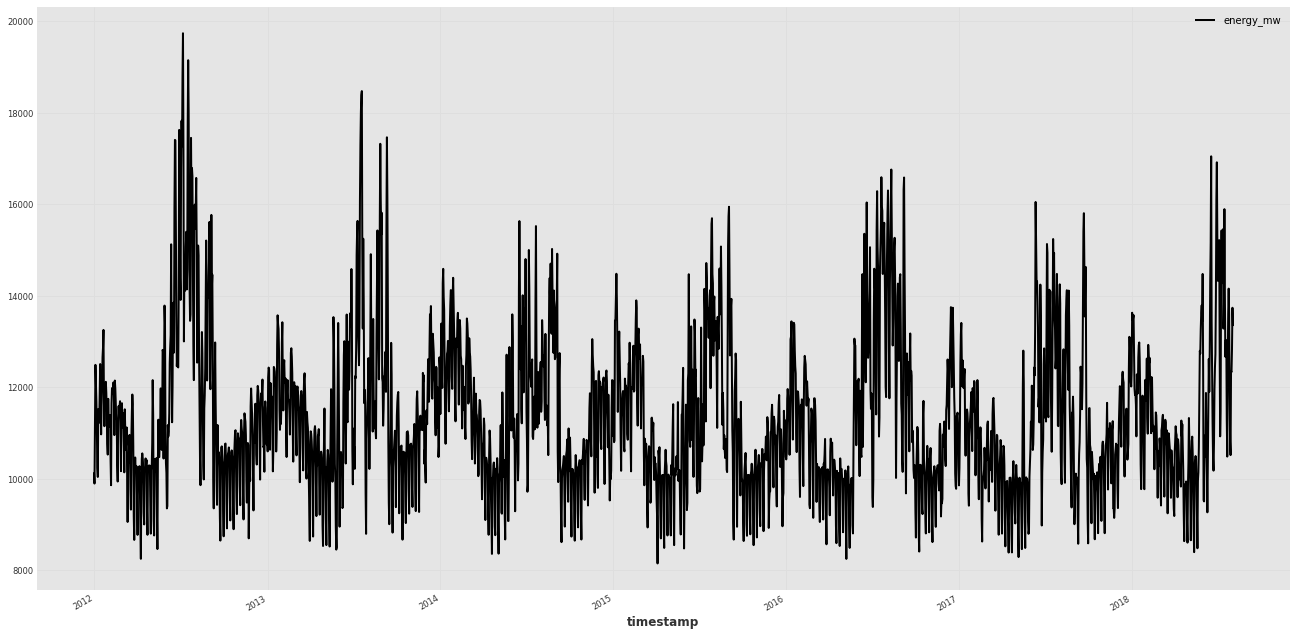

In [16]:
df['timestamp'] = pd.to_datetime(df['timestamp'], utc=True)
df['timestamp'] = df.timestamp.dt.tz_localize(None)

df_day_avg = df.groupby(df['timestamp'].astype(str).str.split(" ").str[0]).mean().reset_index()
value_filler = MissingValuesFiller()
series = value_filler.transform(TimeSeries.from_dataframe(df_day_avg, 'timestamp', ['energy_mw']))
series.plot()

In [17]:
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries

train, val = series.split_after(pd.Timestamp('20170901'))
scaler = Scaler()
train_transformed = scaler.fit_transform(train)
val_transformed = scaler.transform(val)
series_transformed = scaler.transform(series)

In [18]:
# add the day as a covariate
day_series = datetime_attribute_timeseries(
    series_transformed, attribute="day", one_hot=True
)
scaler_day = Scaler()
day_series = scaler_day.fit_transform(day_series)
train_day, val_day = day_series.split_after(pd.Timestamp("20170901"))


Next step is to create the Temporal Convolution Network:

In [19]:
from darts.models import TCNModel

model = TCNModel(
    n_epochs = 2, 
    input_chunk_length = 365,
    output_chunk_length = 7,  # weekly forecast 
    dropout=0, 
    dilation_base=2, 
    weight_norm=True,
    kernel_size=7,
    num_filters=4,
    random_state=0
)

In [20]:
# model.fit(series=train_transformed, past_covariates=train_day, verbose=True)

We will use the backtesting functionality provided in `darts`: 

In [21]:
from darts.metrics import rmse 

forecast_horizon = 7
last_obs = 400

            
backtest = model.historical_forecasts(
    series=series_transformed,
    past_covariates=day_series,
    start=0.7,
    forecast_horizon=7,
    stride= 7,
    retrain= True, verbose=False,
)




Training: 0it [00:00, ?it/s]

Predicting: 42it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 42it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 42it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 42it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 42it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 43it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 43it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 43it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 43it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 43it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 44it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 44it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 44it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 44it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 45it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 45it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 45it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 45it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 45it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 46it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 46it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 46it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 46it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 47it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 47it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 47it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 47it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 47it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 48it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 48it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 48it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 48it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 49it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 49it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 49it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 49it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 49it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 50it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 50it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 50it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 50it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 50it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 51it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 51it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 51it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 51it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 52it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 52it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 52it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 52it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 52it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 53it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 53it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 53it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 53it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 54it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 54it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 54it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 54it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 54it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 55it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 55it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 55it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 55it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 56it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 56it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 56it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 56it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 56it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 57it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 57it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 57it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 57it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 57it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 58it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 58it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 58it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 58it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 59it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 59it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 59it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 59it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 59it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 60it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 60it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 60it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 60it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 61it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 61it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 61it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 61it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 61it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 62it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 62it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 62it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 62it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 63it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 63it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 63it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 63it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 63it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 64it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 64it [00:00, ?it/s]

Backtest RMSE = 0.12


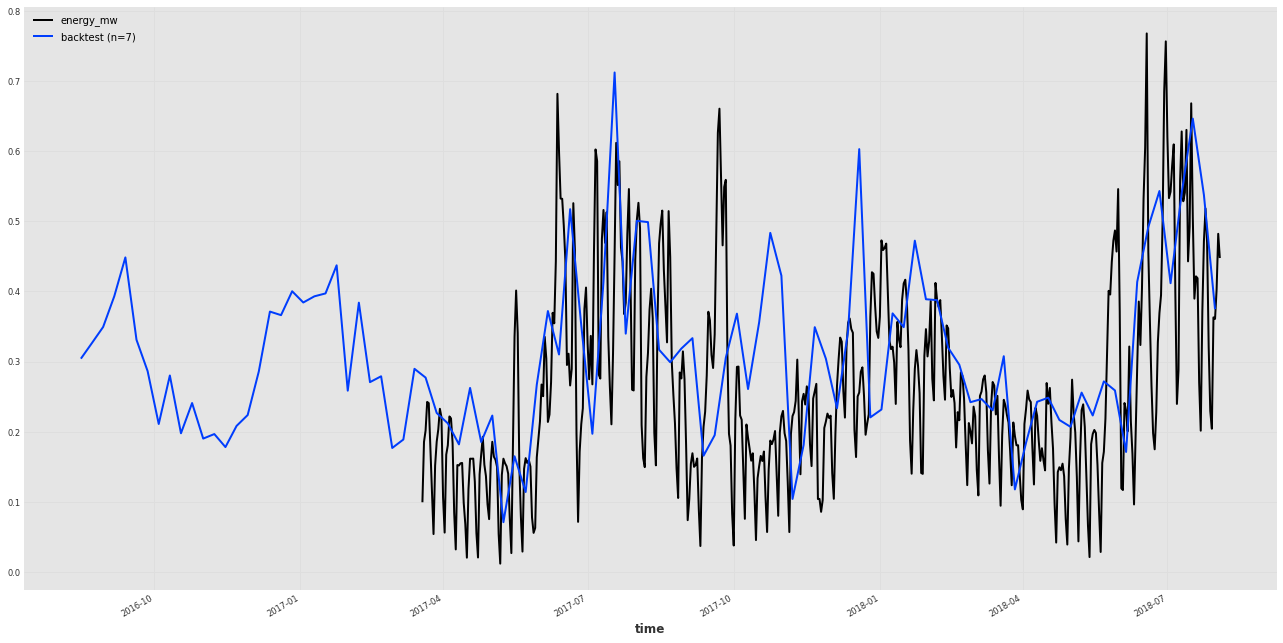

In [22]:
series_transformed[-len(backtest) - last_obs:].plot()
backtest.plot(label='backtest (n=' + str(forecast_horizon) + ')')

print('Backtest RMSE = {}'.format(np.round( rmse(series_transformed, backtest),2 )))

Staying within the `darts` framework, let's have a look at another slightly exotic model.

<a id="nbeats"></a>
# N-BEATS


M4 finished in 2018 - but when in 2019 **NBEATS** was proposed, the authors decided to use data from that competition to test their idea and reported superior performance compared to ES-RNN. That was the part that caught my attention. 


[Source](https://arxiv.org/abs/1905.10437)

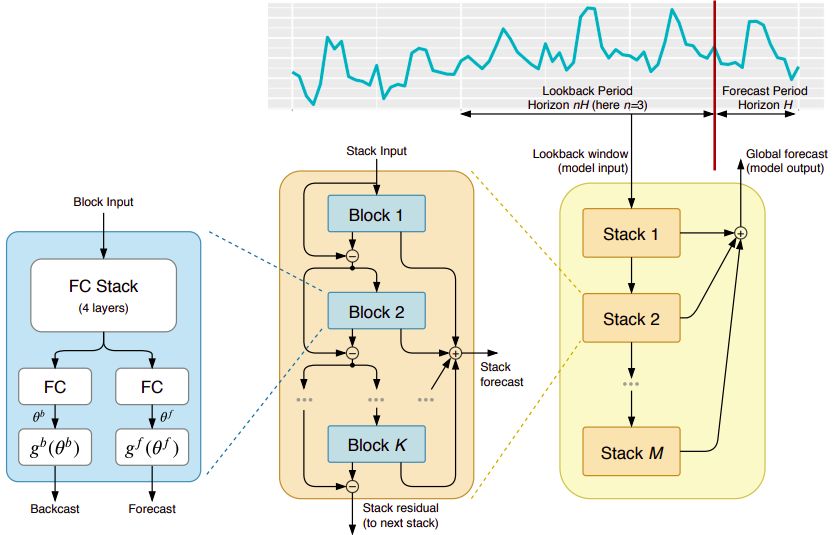


The original paper can be found [here](https://arxiv.org/abs/1905.10437), brief summary follows:

* an architecture designed specifically for time series (vs adaptation like RNN / LSTM which translate sequences)

* created using the same type of basic building block containing one input and two outputs (forecast and backcast)

* core idea: 1. take an entire window of past values 2. compute many forecast timepoints values in a single pass

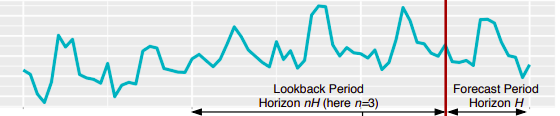


* M stacks of K blocks, all blocks within each stack can share learnable parameters

* blocks connect feedforward networks via forecast and backcast links

* each block has four FC layers with ReLU activations before splitting into forecast and backcast branches. Each branch has one more fully connected layer without activation, and then a linear basis layer that can be either learned or instead engineered to account for different effects such as trend and seasonality. 

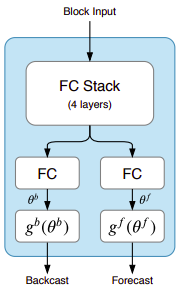

Taking concrete **example**: 

* forecast = 5, lookback = 15

* 15-dim input from lookbacck is past through the4 layer [FC+Relu] stack and split afterwards 

* Each of which is further passed through another FC and finally we get two outputs: 15dim Backcast and a 5dim Forecast. 

* This Basic Block learns to predict not only the future data points in the form of Forecast but also predicts the input data as well in the form of Backcast

[Source](https://kshavg.medium.com/n-beats-neural-basis-expansion-analysis-for-interpretable-time-series-forecasting-91e94c830393)

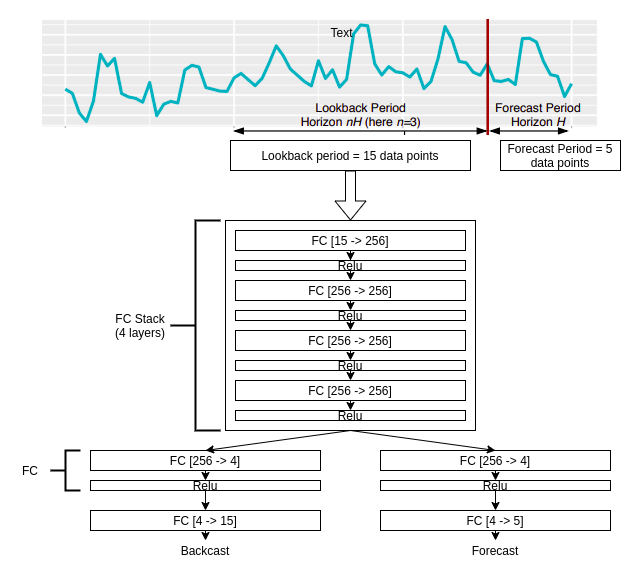



* a block removes "the portion of the signal … it can approximate well" $\rightarrow$ focus on the residual error

* Each block generates a partial forecast focused on the local characteristics of the time series

* The stack aggregates the partial forecasts across the blocks it comprises and then hands the result over to the next stack. The stacks’ purpose is to identify non-local patterns along the complete time axis by “looking back.”

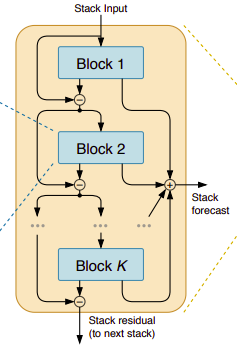


* single stack consists of multiple blocks, arranged $\sim$ **Double** Residual Stacking $\rightarrow$ two arithmetic operations (backcast and forecast)

Continuing prev **example**:

* 15 dim input of the Lookback Period (Lookback_inp) is passed through Block 1 $\implies$ Backcast_1, Forecast_1

* 15 dim input to Block 2 will be  Backcast_1-Lookback_inp  By subtracting Lookback_inp from Backcast_1, a vector which incorporates only those learnings not learned enough by Block 1 will be passed as input to Block 2.

* same logic is applied in the following blocks 

* forecast output of all blocks in the stack will be added element-wise $\implies$ stack forecast output


* global model output is the sum of forecasts of all blocks in the network, while the backcasts are subtracted from the previous inputs to create the input for the following block $\sim$ boosted-trees

* stacking of residual blocks avoids issues with gradient vanivshing

* specialized trend / frequency blocks can be used 

* global output is a sum of partials $\implies$ **interpretability** based on contribution of components

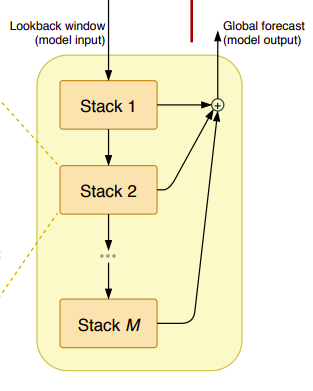


Pros:
* easy to parallelize $\rightarrow$ speed advantage over RNN

* light $\rightarrow$ useful for embedded devices 

Cons:
* backcast / forecast need to be configured per model / problem



How do we use this awesome machinery in practice?

In [23]:
from darts import concatenate
from darts.models import NBEATSModel
from darts.metrics import mape, rmse
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import QuantileRegression


Hyperparameters: 

- sizes of the input and output layers  should be adequate to assign a node to each feature in the source data

- input chunk length $\geq$ order of seasonality

- number of blocks in a stack

- width of each fully connected layer in each block of a stack: its node count 


In [24]:

EPOCHS = 5
INLEN = 32          # input size
BLOCKS = 64         
LWIDTH = 32
BATCH = 64          # batch size
LEARN = 1e-3        # learning rate
VALWAIT = 1         # epochs to wait before evaluating the loss on the test/validation set
N_FC = 1            # output size
RAND = 42           # random seed
N_JOBS = -1          # parallel processors to use;  -1 = all processors


SPLIT = 0.9         # train/test split


# parameters for the probabilistic forecast
N_SAMPLES = 100     # number of times a prediction is sampled from a probabilistic model
QUANTILES = [0.01, 0.1, 0.2, 0.5, 0.8, 0.9, 0.99]
qL1, qL2 = 0.01, 0.10                     # percentiles of predictions: lower bounds
qU1, qU2 = 1-qL1, 1-qL2,                  # upper bounds derived from lower bounds
label_q1 = f'{int(qU1 * 100)} / {int(qL1 * 100)} percentile band'
label_q2 = f'{int(qU2 * 100)} / {int(qL2 * 100)} percentile band'


Recycling is good and eco-friendly $\implies$ we will re-use the energy consumption data from the previous section.

In [25]:
model = NBEATSModel(    input_chunk_length=INLEN,
                        output_chunk_length=N_FC, 
                        num_stacks=BLOCKS,
                        layer_widths=LWIDTH,
                        batch_size=BATCH,
                        n_epochs=EPOCHS,
                        nr_epochs_val_period=VALWAIT, 
                        likelihood=QuantileRegression(QUANTILES), 
                        optimizer_kwargs={"lr": LEARN}, 
                        model_name="NBEATS_EnergyES",
                        log_tensorboard=True,
                        generic_architecture=True, 
                        random_state=RAND,
                        force_reset=True,
                        save_checkpoints=True
                    )

In [26]:

forecast_horizon = 7
last_obs = 400

            
backtest = model.historical_forecasts(
    series=series_transformed,
    past_covariates=day_series,
    start=0.7,
    forecast_horizon=7,
    stride= 7,
    retrain= True, verbose=False,
)


/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:1937: PossibleUserWarning: The number of training batches (26) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:378: UserWarning: `ModelCheckpoint(monitor='val_loss')` could not find the monitored key in the returned metrics: ['train_loss', 'epoch', 'step']. HINT: Did you call `log('val_loss', value)` in the `LightningModule`?
  warning_cache.warn(m)


Predicting: 26it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:611: UserWarning: Checkpoint directory /kaggle/working/darts_logs/NBEATS_EnergyES/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Training: 0it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:1937: PossibleUserWarning: The number of training batches (27) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Predicting: 27it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 27it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 27it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 27it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 27it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 27it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 27it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 27it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 27it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:1937: PossibleUserWarning: The number of training batches (28) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Predicting: 28it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 28it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 28it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 28it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 28it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 28it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 28it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 28it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 28it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 28it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:1937: PossibleUserWarning: The number of training batches (29) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Predicting: 29it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 29it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 29it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 29it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 29it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 29it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 29it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 29it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 29it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:1937: PossibleUserWarning: The number of training batches (30) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Predicting: 30it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 30it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 30it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 30it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 30it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 30it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 30it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 30it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 30it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:1937: PossibleUserWarning: The number of training batches (31) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Predicting: 31it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 31it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 31it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 31it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 31it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 31it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 31it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 31it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 31it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:1937: PossibleUserWarning: The number of training batches (32) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Predicting: 32it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 32it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 32it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 32it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 32it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 32it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 32it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 32it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 32it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:1937: PossibleUserWarning: The number of training batches (33) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:1937: PossibleUserWarning: The number of training batches (34) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Predicting: 34it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 34it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 34it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 34it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 34it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 34it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 34it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 34it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 34it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:1937: PossibleUserWarning: The number of training batches (35) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Predicting: 35it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 35it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 35it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 35it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 35it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 35it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 35it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 35it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 35it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 35it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:1937: PossibleUserWarning: The number of training batches (36) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Predicting: 36it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 36it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 36it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 36it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 36it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 36it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 36it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 36it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 36it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:1937: PossibleUserWarning: The number of training batches (37) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Predicting: 37it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 37it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 37it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 37it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 37it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 37it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 37it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 37it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 37it [00:00, ?it/s]

Backtest RMSE = 0.17


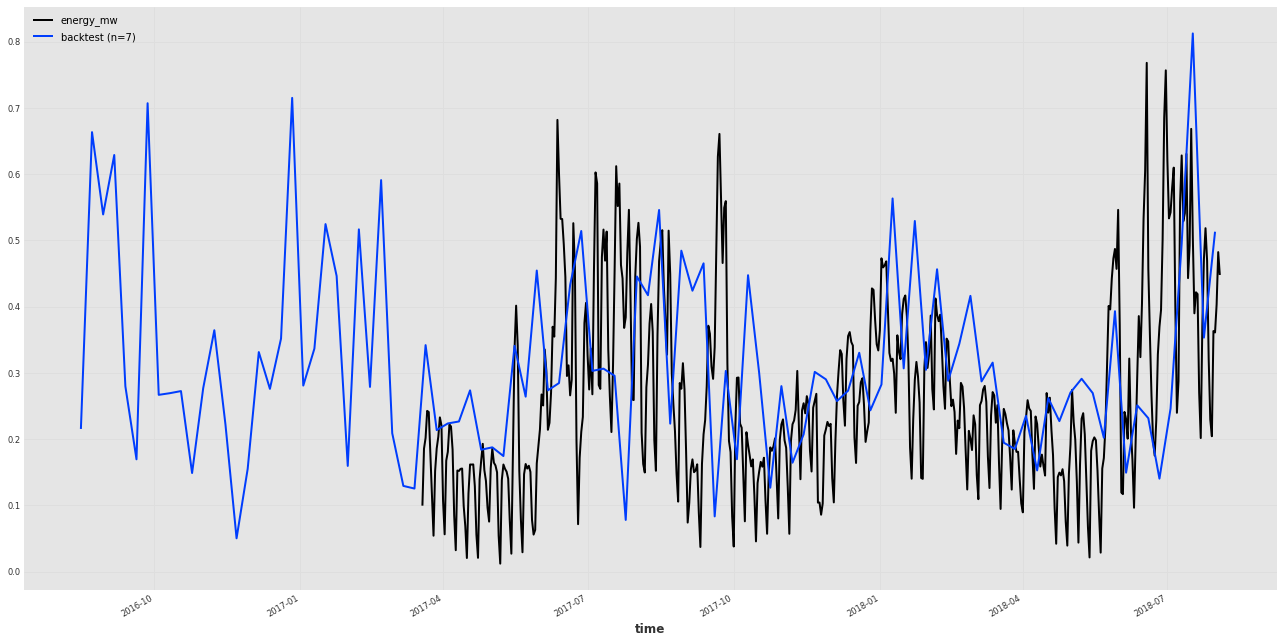

In [27]:

series_transformed[-len(backtest) - last_obs:].plot()
backtest.plot(label='backtest (n=' + str(forecast_horizon) + ')')

print('Backtest RMSE = {}'.format(np.round( rmse(series_transformed, backtest) , 2 )))